In [20]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot
from keras import backend as K
from keract import get_activations, display_activations
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.sbx import SBX
from pymoo.core.problem import Problem, ElementwiseProblem
import pandas as pd
import random as rng

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


11490434/11490434 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [4]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/15
422/422 [==============================] - 9s 19ms/step - loss: 0.3823 - accuracy: 0.8847 - val_loss: 0.0899 - val_accuracy: 0.9758
Epoch 2/15
422/422 [==============================] - 8s 19ms/step - loss: 0.1127 - accuracy: 0.9654 - val_loss: 0.0577 - val_accuracy: 0.9847
Epoch 3/15
422/422 [==============================] - 8s 18ms/step - loss: 0.0844 - accuracy: 0.9739 - val_loss: 0.0441 - val_accuracy: 0.9888
Epoch 4/15
422/422 [==============================] - 8s 19ms/step - loss: 0.0714 - accuracy: 0.9776 - val_loss: 0.0391 - val_accuracy: 0.9905
Epoch 5/15
422/422 [==============================] - 8s 19ms/step - loss: 0.0613 - accuracy: 0.9810 - val_loss: 0.0392 - val_accuracy: 0.9885
Epoch 6/15
422/422 [==============================] - 8s 19ms/step - loss: 0.0559 - accuracy: 0.9826 - val_loss: 0.0334 - val_accuracy: 0.9910
Epoch 7/15
422/422 [==============================] - 8s 19ms/step - loss: 0.0506 - accuracy: 0.9837 - val_loss: 0.0338 - val_accuracy: 0.9912

In [6]:
score = model.evaluate(x_test, y_test, verbose=0)

# nodes = 0
# non_zero_nodes = 0

# for n in range(0, len(model.layers)):
#     get_nth_layer_output = K.function([model.layers[0].input], [model.layers[n].output])
#     layer_output = get_nth_layer_output([x_test])[0]
#     nodes += layer_output.size
#     non_zero_nodes += np.count_nonzero(layer_output)


# neuron_coverage = non_zero_nodes / nodes

# print("Neuron coverage:", neuron_coverage)

#******************************************************************************************************************#
#******************************************************************************************************************#
#******************************************************************************************************************#
#******************************************************************************************************************#

def Neuron_Activation_Coverage(model, input_img):
    
    if len(input_img.shape) < 4:
        input_img = np.expand_dims(input_img, axis=0)

    activations = get_activations(model, input_img, auto_compile=True)
    del activations["input_1"]

    total_nodes = 0
    non_zeros = 0
    for value in activations.values():
        total_nodes += value.size
        non_zeros += np.count_nonzero(value)

    return non_zeros / total_nodes

nac = Neuron_Activation_Coverage(model, x_test[0])

print("NAC: ", nac)
    
# [print(k, '->', v.shape, '- Numpy array') for (k, v) in activations.items()]

# display_activations(activations, cmap=None, save=False, directory='.', data_format='channels_last', fig_size=(24, 24), reshape_1d_layers=False)


NAC:  0.27350103551043087


In [42]:
class NCMax(ElementwiseProblem):
    def __init__(self, input_img):
        super().__init__(
            n_var=784, n_obj=1, n_constr=0, xl=0.0, xu=1.0)
        self.input_img = input_img
    
    def _evaluate(self, x, out, *args, **kwargs):
        x = np.reshape(x, (28, 28, 1))
        perturbed_img = self.input_img + x
        nc = Neuron_Activation_Coverage(model, perturbed_img)
        ret_val = 1.0 / nc
        out["F"] = ret_val

alg = NSGA2(pop_size = 30, offsprings=30,
            sampling=FloatRandomSampling(),
            crossovers=SBX(),
            mutation=PolynomialMutation(),)

challenging_images = np.zeros(shape=(10000, 28, 28, 1))

random_indexes = rng.sample(range(0, 10000), 100)

for i in range(0, 100):
    problem = NCMax(x_test[random_indexes[i]])
    
    res = minimize(problem, alg, ("n_gen", 5))
    if res.X.size > 784:
        noise = np.reshape(res.X[0], (28, 28, 1))
    else:
        noise = np.reshape(res.X, (28, 28, 1))

    challenging_img = x_test[random_indexes[i]] + noise
    challenging_images[i] = challenging_img

x_test_nacs = []
challenging_images_nacs = []
absolute_increase = []
relative_increase = []

for i in range(0, 100):
    pre_NSGA = Neuron_Activation_Coverage(model, x_test[random_indexes[i]])
    post_NSGA = Neuron_Activation_Coverage(model, challenging_images[i])
    x_test_nacs.append(pre_NSGA)
    challenging_images_nacs.append(post_NSGA)
    absolute_increase.append(post_NSGA - pre_NSGA)
    relative_increase.append((post_NSGA - pre_NSGA) / pre_NSGA)
    

In [43]:
dataset = {
    "Normal Images": x_test_nacs,
    "Challenging Images": challenging_images_nacs,
    "Absolute Increase": absolute_increase,
    "Relative Increase": relative_increase
}

table = pd.DataFrame(dataset)
table.index += 1

table.to_excel("temp.xlsx")

In [33]:
# for i in range(9):  
#     pyplot.subplot(330 + 1 + i)
#     pyplot.imshow(challenging_images[0], cmap=pyplot.get_cmap('gray'))
#     pyplot.show()

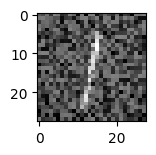

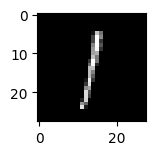

In [46]:
pyplot.subplot(330 + 1)
pyplot.imshow(challenging_images[67], cmap=pyplot.get_cmap('gray'))
pyplot.show()

pyplot.subplot(330 + 1)
pyplot.imshow(x_test[random_indexes[67]], cmap=pyplot.get_cmap('gray'))
pyplot.show()